In [1]:
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers


# Dataset Paths
base_dir = '/kaggle/input/dataset/DeepFish/Classification/organized'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


In [2]:
img_size = (128, 128)  # VGG16 expects input sizes of at least 32x32, but larger is better
batch_size = 32
num_classes = 9  # Number of habitats

# Data Generators with Rescaling
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)


Found 3124 images belonging to 9 classes.
Found 770 images belonging to 9 classes.
Found 3872 images belonging to 9 classes.


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [4]:
vgg16 = VGG16(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,  # Exclude the top layers for transfer learning
    input_shape=(img_size[0], img_size[1], 3)  # Input shape
)

# Freeze the layers in VGG16 base model to retain pre-trained features
for layer in vgg16.layers:
    layer.trainable = False

# Add custom classification layers on top of VGG16

model = Sequential([
    vgg16,  # Include VGG16 model as feature extractor
    GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Add dense layer with L2 regularization
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Another dense layer
    Dropout(0.5),  # Dropout for regularization
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])  # Output layer

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,789,193 (56.42 MB)

 Trainable params: 74,505 (291.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
history = model.fit(
    train_generator,
    epochs=10,  # Number of epochs
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 74s 631ms/step - accuracy: 0.1646 - loss: 5.0975 - val_accuracy: 0.4117 - val_loss: 4.3280
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 36s 343ms/step - accuracy: 0.2550 - loss: 4.3233 - val_accuracy: 0.4117 - val_loss: 3.8210
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 36s 346ms/step - accuracy: 0.3319 - loss: 3.8129 - val_accuracy: 0.4117 - val_loss: 3.3852
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 35s 339ms/step - accuracy: 0.4176 - loss: 3.3825 - val_accuracy: 0.5636 - val_loss: 2.9958
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 36s 344ms/step - accuracy: 0.4824 - loss: 3.0057 - val_accuracy: 0.5675 - val_loss: 2.6513
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 35s 332ms/step - accuracy: 0.5103 - loss: 2.7165 - val_accuracy: 0.7610 - val_loss: 2.3505
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 36s 345ms/step - accuracy: 0.5547 - loss: 2.4528 - val_accuracy: 0.8026 - val_loss: 2.1003
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 36s 342ms/step - accuracy: 0.6088 - loss: 2.2174 - val_accuracy: 0.807

In [8]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

121/121 ━━━━━━━━━━━━━━━━━━━━ 54s 445ms/step - accuracy: 0.8776 - loss: 1.5114
Test Accuracy: 87.22%


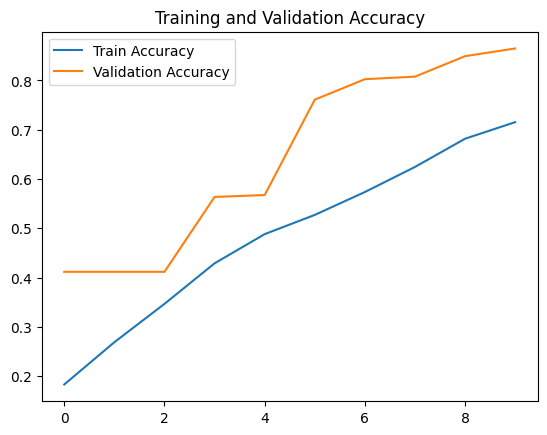

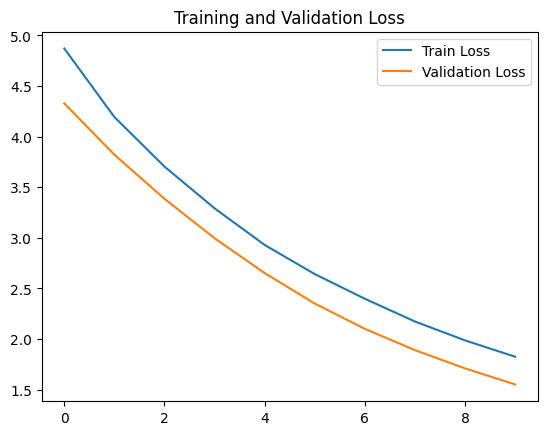

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


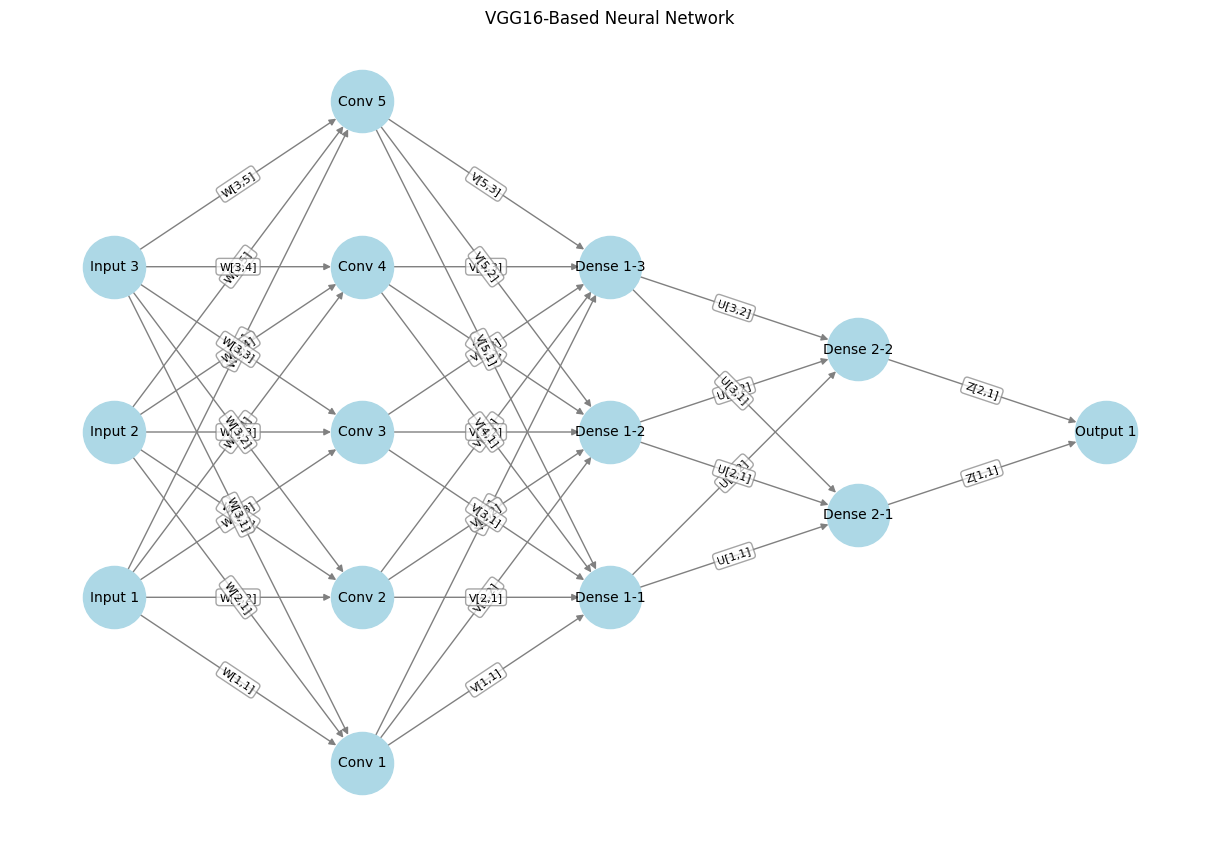

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_vgg16_like_neural_network():
    """
    Plots a simplified neural network diagram inspired by the VGG16 architecture,
    showing non-overlapping weights and clear annotations.
    """

    # Create a directed graph
    G = nx.DiGraph()

    # Define layers with fewer neurons for visualization
    input_size = 3  # RGB input channels
    hidden_size_1 = 5  # Example for a reduced feature extractor
    hidden_size_2 = 3  # Dense layer 1 (128 neurons simplified)
    hidden_size_3 = 2  # Dense layer 2 (64 neurons simplified)
    output_size = 1  # Example for multi-class classification (3 classes)

    # Add nodes for each layer
    for i in range(input_size):
        G.add_node(f"Input {i+1}", layer=0)

    for h1 in range(hidden_size_1):
        G.add_node(f"Conv {h1+1}", layer=1)

    for h2 in range(hidden_size_2):
        G.add_node(f"Dense 1-{h2+1}", layer=2)

    for h3 in range(hidden_size_3):
        G.add_node(f"Dense 2-{h3+1}", layer=3)

    for o in range(output_size):
        G.add_node(f"Output {o+1}", layer=4)

    # Add edges with symbolic weights between layers
    edge_labels = {}
    for i in range(input_size):
        for h1 in range(hidden_size_1):
            edge_label = f"W[{i+1},{h1+1}]"
            G.add_edge(f"Input {i+1}", f"Conv {h1+1}")
            edge_labels[(f"Input {i+1}", f"Conv {h1+1}")] = edge_label

    for h1 in range(hidden_size_1):
        for h2 in range(hidden_size_2):
            edge_label = f"V[{h1+1},{h2+1}]"
            G.add_edge(f"Conv {h1+1}", f"Dense 1-{h2+1}")
            edge_labels[(f"Conv {h1+1}", f"Dense 1-{h2+1}")] = edge_label

    for h2 in range(hidden_size_2):
        for h3 in range(hidden_size_3):
            edge_label = f"U[{h2+1},{h3+1}]"
            G.add_edge(f"Dense 1-{h2+1}", f"Dense 2-{h3+1}")
            edge_labels[(f"Dense 1-{h2+1}", f"Dense 2-{h3+1}")] = edge_label

    for h3 in range(hidden_size_3):
        for o in range(output_size):
            edge_label = f"Z[{h3+1},{o+1}]"
            G.add_edge(f"Dense 2-{h3+1}", f"Output {o+1}")
            edge_labels[(f"Dense 2-{h3+1}", f"Output {o+1}")] = edge_label

    # Define positions for a layered layout
    pos = {}
    layer_dist = 1.5  # Distance between layers
    node_dist = 1  # Distance between nodes

    # Position nodes for each layer
    for i in range(input_size):
        pos[f"Input {i+1}"] = (0, i * node_dist - (input_size - 1) * node_dist / 2)

    for h1 in range(hidden_size_1):
        pos[f"Conv {h1+1}"] = (layer_dist, h1 * node_dist - (hidden_size_1 - 1) * node_dist / 2)

    for h2 in range(hidden_size_2):
        pos[f"Dense 1-{h2+1}"] = (2 * layer_dist, h2 * node_dist - (hidden_size_2 - 1) * node_dist / 2)

    for h3 in range(hidden_size_3):
        pos[f"Dense 2-{h3+1}"] = (3 * layer_dist, h3 * node_dist - (hidden_size_3 - 1) * node_dist / 2)

    for o in range(output_size):
        pos[f"Output {o+1}"] = (4 * layer_dist, o * node_dist - (output_size - 1) * node_dist / 2)

    # Plot the network
    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightblue",
        edge_color="gray",
        node_size=2000,
        font_size=10,
    )

    # Draw edge labels for symbolic weights with adjusted positioning to avoid overlap
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_labels,
        font_size=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.7),
        label_pos=0.5,  # Place labels at the midpoint of the edges
    )
    plt.title("VGG16-Based Neural Network")
    plt.show()


# Call the function to plot the network
plot_vgg16_like_neural_network()
